# Medium Baseline
你可以通过搜索 "Medium" 来检查是哪些地方做了改变 (Ctrl + F 或者 Command + F)

# 作业描述
- 英译中(繁体)
  - 输入: an English sentence         (e.g.		tom is a student .)
  - 输出: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - 训练一个 seq2seq 的简单的 RNN 模型来完成翻译
    - 转变模型架构为 transformer，提升性能
    - 使用 Back-translation 进一步提升性能

In [1]:
!nvidia-smi

Wed Nov 15 18:12:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   28C    P8    20W / 170W |    367MiB / 12288MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 下载和导入需要的包

In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 3f6ba43
!pip install --upgrade ./fairseq/

In [4]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 固定随机数种子

In [5]:
seed = 33
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 数据集

## 英-中 对应的语料
* TED2020
    - 原始: 400,726 (句子)   
    - 处理后: 394,052 (句子)
    

## 测试集
- 大小: 4,000 (句子)
- **没有提供中文的翻译。(.zh)文件是伪翻译，其中每一行是'。'**

## 数据集下载

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.data.tgz",
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.test.tgz"
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## 语言

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 预处理文件
- strQ2B(): 将全角字符转变为半角字符
- clean_s(): 清洗文本，将逗号/破折号/空格等字符删除
- len_s(): 返回文本长度
- clean_corpus: 使用上面的函数对指定的文本文件进行清洗

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)

def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 划分训练/验证集

In [12]:
valid_ratio = 0.01 # 3000～4000 就够用了
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## 子词单位
不在词表中的单词（OOV）是机器翻译面临的主要问题。这个问题可以通过使用子词（subword）作为基本单位来缓解
- 我们将使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 包
- 选择 unigram 或者 byte-pair encoding (BPE) 算法

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁tr u ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## 数据二值化（使用 fairseq）
配对源语言和目标语言的文件。

如果没有对应的文件，就生成伪配对来方便二值化。

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# 实验配置

In [18]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = src_lang,
    target_lang = tgt_lang,

    # 设置取数据和处理数据时 cpu 的线程数
    num_workers=2,
    # batch size 按照 token 数量来计算。梯度累积可以增加有效的 batch size。
    max_tokens=8192,
    accum_steps=2,

    # 学习率通过 Noam 调度器进行计算。你可以修改lr_factor来调整最大的学习率。
    lr_factor=2.,
    lr_warmup=4000,

    # 梯度裁剪可以缓解梯度爆炸
    clip_norm=1.0,

    # 训练的最大轮数 (Medium)
    max_epoch=30,
    start_epoch=1,

    # 集束搜索中的 beam size
    beam=5,
    # 生成的序列的最大长度为 ax + b，其中 x 是源长度
    max_len_a=1.2,
    max_len_b=10,
    # 解码时，通过去除 sentencepiece 符号和 jieba 分词来后处理句子。
    post_process = "sentencepiece",

    # 检查点
    keep_last_epochs=5,
    resume=None, # if resume 则根据 checkpoint name 进行恢复（文件保存在 config.savedir 下）

    # 日志记录
    use_wandb=False,
)

# 日志
- logging 包用于记录普通的信息
- wandb 记录训练过程中的损失/bleu等

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA 环境

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-11-15 18:13:17 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-11-15 18:13:17 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 11.759 GB ; name = NVIDIA GeForce RTX 3060                 
2023-11-15 18:13:17 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 数据导入

## 我们采用了 TranslationTask（来自 fairseq）
* 用于加载上面创建的二值化数据
* 实现数据迭代器（dataloader）
* 内置的 task.source_dictionary 和 task.target_dictionary 也很有用
* 实现集束搜索解码器

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-11-15 18:13:17 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2023-11-15 18:13:17 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-11-15 18:13:17 | INFO | hw5.seq2seq | loading data for epoch 1
2023-11-15 18:13:17 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2023-11-15 18:13:17 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2023-11-15 18:13:17 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390112 examples
2023-11-15 18:13:17 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2023-11-15 18:13:17 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2023-11-15 18:13:17 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3940 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  24,   63,    5,   90, 1323,  143,  140,  184,  281,   37,    8,   81,
         254,   11,   80,   55,   12,  376,   20,  155,   60, 1007,   98,  587,
          76,  256,    6,   98, 1465,    7,    2]),
 'target': tensor([ 162,  116, 3756,  364,  158, 3055, 2925,    9, 2547,    4,  596,  123,
        1518,  455,  667,   64,  406,  566,   74, 1908, 3790,  191,   10,    2])}
('Source: you can throw out crazy theories and not have to back it up with '
 'data or graphs or research .')
'Target: 你能拋開這些瘋狂的理論 , 不用數據圖表、或研究來支撐它 。'


# 数据集迭代器

* 控制每个 batch 不超过 N 个 token，这样可以优化 GPU 内存效率
* 在每个 epoch 都对训练集进行随机打乱
* 忽略超过最大长度的句子
* 将一个 batch 中的所有句子填充到相同的长度，这样可以利用 GPU 进行并行计算
* 添加 eos 并移动一个 token
    - teacher forcing 技术: 为了训练模型根据前缀预测下一个 token，我们将移动后的目标序列作为解码器的输入。
    - 一般来说，在目标前面加上 bos 就可以了（如下图所示）
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - 但是在 fairseq 中，这是通过将 eos token 移动到开头来实现的。在实验上，这个操作拥有相同的效果。例如:
    ```
    # 目标输出（target）和解码器输入（prev_output_tokens）:
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [24]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # 如果设置为 False（cached=True），可以加快训练速度。
        # 但是，如果设置为 False，那么在第一次调用这个方法之后，再改变 max_tokens就没有效果了。
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-11-15 18:13:17 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = False
2023-11-15 18:13:17 | INFO | fairseq.tasks.fairseq_task | reuse_dataloader = True
2023-11-15 18:13:17 | INFO | fairseq.tasks.fairseq_task | rebuild_batches = False
2023-11-15 18:13:17 | INFO | fairseq.tasks.fairseq_task | creating new batches for epoch 1
2023-11-15 18:13:17 | WARNING | fairseq.tasks.fairseq_task | 2,494 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1856, 2936, 3373, 918, 3863, 3540, 1791, 1246, 1790, 251]


{'id': tensor([3381]),
 'nsentences': 1,
 'ntokens': 12,
 'net_input': {'src_tokens': tensor([[  11,  260,  296,    4,   16, 1083,   19,   14,   34,  233,    4,  260,
           1604,  105,    7,    2]]),
  'src_lengths': tensor([16]),
  'prev_output_tokens': tensor([[   2, 1612,    4, 2475, 1797,    4,  241,  470, 2203, 2835,   35,   10,
              1,    1,    1,    1]])},
 'target': tensor([[1612,    4, 2475, 1797,    4,  241,  470, 2203, 2835,   35,   10,    2,
             1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# 模型架构
* 我们再次继承 fairseq 的编码器、解码器和模型，以便在测试阶段可以直接利用 fairseq 的集束搜索解码器。

In [25]:
from fairseq.models import (
    FairseqEncoder,
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# 编码器

- 编码器（Encoder）是一个循环神经网络（RNN）或者 Transformer 中的编码器。下面的描述是针对 RNN 的。对于每一个输入的 token，编码器会生成一个输出向量和一个隐藏状态向量，并且将隐藏状态向量传递给下一步。换句话说，编码器顺序地读入输入序列，并且在每一个时间步输出一个单独的向量，然后在最后一个时间步输出最终的隐藏状态，或者称为内容向量（content vector）。
- 参数:
  - *args*
      - encoder_embed_dim: 嵌入的维度，将 one-hot 向量压缩到固定的维度，实现降维的效果
      - encoder_ffn_embed_dim: 隐藏状态和输出向量的维度
      - encoder_layers: RNN 编码器的层数
      - dropout 确定了一个神经元的激活值被设为 0 的概率，用于防止过拟合。通常这个参数在训练时使用，在测试时移除
  - *dictionary*: fairseq 提供的字典。它用于获取填充索引，进而得到编码器的填充掩码（encoder padding mask）
  - *embed_tokens*: 一个 token embedding 的实例（nn.Embedding）

- Inputs:
    - *src_tokens*: 一个表示英语的整数序列，例如: 1, 28, 29, 205, 2
- Outputs:
    - *outputs*: RNN 在每个时间步的输出，可以由注意力机制（Attention）进一步处理
    - *final_hiddens*: 每个时间步的隐藏状态，会被传递给解码器（decoder）进行解码
    - *encoder_padding_mask*: 这个参数告诉解码器哪些位置要忽略


In [26]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens

        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers

        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=args.dropout,
            batch_first=False,
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)

        self.padding_idx = dictionary.pad()

    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()

        # 获取 embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # 经过双向的 RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]

        # 由于编码器是双向的，我们需要将两个方向的隐藏状态连接起来
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]

        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )

    def reorder_encoder_out(self, encoder_out, new_order):
        # 这个被用于 fairseq 的集束搜索。它的具体细节和原因并不重要。
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## 注意力

- 当输入序列很长时，单独的“内容向量”就不能准确地表示整个序列，注意力机制可以为解码器提供更多信息。
- 根据当前时间步的**解码器embeddings**，将**编码器输出**与**解码器 embeddings** 进行匹配，确定相关性，然后将编码器输出按相关性加权求和作为**解码器** RNN 的输入。
- 常见的注意力实现使用神经网络/点积作为 **query**（解码器 embeddings）和 **key**（编码器输出）之间的相关性，然后用 **softmax** 得到一个分布，最后用该分布对 **value**（编码器输出）进行**加权求和**。

- 参数:
  - *input_embed_dim*: key 的维度，应该是解码器中用于 attend 其他向量的向量的维度
  - *source_embed_dim*: query 的维度，应该是被 attend 的向量（编码器输出）的维度
  - *output_embed_dim*: value 的维度，应该是 after attention 的向量的维度，符合下一层的期望,
- Inputs:
    - *inputs*: key, 用于 attend 其他向量
    - *encoder_outputs*:  query/value, 被 attend 的向量
    - *encoder_padding_mask*: 这个告诉解码器应该忽略那些位置
- Outputs:
    - *output*: attention 后的上下文向量
    - *attention score*: attention 的分数


In [27]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B

        # 将所有的输入的维度改为 batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S

        # 投影到 encoder_outputs 的维度
        x = self.input_proj(inputs)

        # 计算 attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 取消与 padding 相对应的位置的 attention
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在与源序列对应的维度上进行 softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) 加权求和
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh

        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# 解码器

* **解码器**的隐藏状态将由**编码器**的最终隐藏状态（the content vector）初始化
* 同时，**解码器**会根据当前时间步的输入（前一时间步的输出）改变其隐藏状态，并生成一个输出
* 注意力机制可以提高性能
* seq2seq 的步骤是在解码器中实现的，这样以后 Seq2Seq 类可以接受 RNN 和 Transformer，而不需要进一步修改。
- 参数:
  - *args*
      - decoder_embed_dim: 解码器嵌入的维度，类似于 encoder_embed_dim
      - decoder_ffn_embed_dim: 解码器 RNN 隐藏状态的维度，类似于 encoder_ffn_embed_dim
      - decoder_layers: RNN 解码器的层数
      - share_decoder_input_output_embed: 通常，解码器的投影矩阵会与解码器输入 embeddings 共享权重
  - *dictionary*: fairseq 提供的字典
  - *embed_tokens*: 一个 token embedding 的实例（nn.Embedding）
- 输入:
    - *prev_output_tokens*: 表示右移目标的整数序列，例如: 1, 28, 29, 205, 2
    - *encoder_out*: 编码器的输出
    - *incremental_state*: 为了加速测试时的解码，我们会保存每个时间步的隐藏状态。详见forward()。
- 输出:
    - *outputs*: 解码器在每个时间步的输出的对数（softmax之前）
    - *extra*: 未使用

In [28]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens

        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""

        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers


        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=args.dropout,
            batch_first=False,
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        )
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)

        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None

        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )

    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 从编码器中提取输出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch

        if incremental_state is not None and len(incremental_state) > 0:
            # 如果保留了上一个时间步的信息，可以从那里继续，而不是从bos开始
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 增量状态不存在，要么是训练时，要么是测试时的第一个时间步
            # 为seq2seq做准备：将编码器的隐藏状态传递给解码器的隐藏状态
            prev_hiddens = encoder_hiddens

        bsz, seqlen = prev_output_tokens.size()

        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)

        # 经过单向的 RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)

        # 投影到 embedding size（如果隐藏状态与 embedding size 不同，并且 share_embedding 为True
        # 就需要做一个额外的投影）
        if self.project_out_dim != None:
            x = self.project_out_dim(x)

        # 投影到 vocab size
        x = self.output_projection(x)

        # T x B x C -> B x T x C
        x = x.transpose(1, 0)

        # if incremental, 则记录当前时间步的隐藏状态，在下一个时间步恢复
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)

        return x, None

    def reorder_incremental_state(self, incremental_state, new_order):
        # 这个被用于 fairseq 的集束搜索。它的具体细节和原因并不重要。
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由**编码器**和**解码器**组成
- 接收输入并传递给**编码器**
- 将**编码器**的输出传递给**解码器**
- **解码器**会根据前一时间步的输出以及**编码器**的输出进行解码
- 解码完成后，返回**解码器**的输出

In [29]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args

    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [30]:
# # 提示: transformer 架构
from fairseq.models.transformer import (
    TransformerEncoder,
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())

    # encoder decoder
    # 提示: TODO: 转变为 TransformerEncoder & TransformerDecoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    # encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # 序列到序列的模型
    model = Seq2Seq(args, encoder, decoder)

    # 初始化 seq2seq 模型很重要, 需要额外的处理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)

    # 权重初始化
    model.apply(init_params)
    return model

## 架构相关配置

为了达成 strong baseline，请参考 [Attention is all you need](#vaswani2017) 中表 3 中 *transformer-base* 的超参数

In [31]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# 提示: 这些是 Transformer 的参数补丁
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True

    args.decoder_attention_heads=4
    args.decoder_normalize_before=True

    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024

    # Transformer 默认参数的补丁（未在上面设置的参数）
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

# add_transformer_args(arch_args)

In [32]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [33]:
model = build_model(arch_args, task)
logger.info(model)

/home/hoperj/miniconda3/envs/DL/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
2023-11-15 18:13:18 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): RNNEncoder(
    (embed_tokens): Embedding(7992, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 512, dropout=0.3, bidirectional=True)
    (dropout_out_module): Dropout(p=0.3, inplace=False)
  )
  (decoder): RNNDecoder(
    (embed_tokens): Embedding(7992, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 1024, dropout=0.3)
    (attention): AttentionLayer(
      (input_proj): Linear(in_features=256, out_features=1024, bias=False)
      (output_proj): Linear(in_features=1280, out_features=256, bias=False)
    )
    (d

# 优化

## 损失(Loss): Label Smoothing Regularization
* 让模型学习生成更少集中的分布，防止过度自信
* 有时候正确答案可能不是唯一的。因此，在计算损失时，我们为错误标签保留一些概率。
* 避免过拟合

代码 [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [34]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce

    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood 负对数似然，当目标是 one-hot 时的交叉熵。下一行代码等同于F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  保留一些其他标签的概率，这样在计算交叉熵的时候相当于对所有标签的对数概率求和
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 在计算交叉熵的时候，增加其他标签的损失
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 通常来说，0.1 已经足够好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## 优化器: Adam + 学习率调度 (Medium)
在训练 Transformer 时，平方根倒数调度（Inverse square root scheduling）对于稳定性非常重要，在后面也用于RNN。
根据以下公式更新学习率，第一阶段线性增加，然后按时间步的平方根倒数成比例衰减。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [35]:
import math

def get_rate(d_model, step_num, warmup_step):
    # TODO: 将 lr 从常数修改为上面显示的公式
    lr = 1.0 / math.sqrt(d_model) * min(1.0 / math.sqrt(step_num), step_num / (warmup_step * math.sqrt(warmup_step)))
    return lr

In [36]:
class NoamOpt:
    "Optim 包装，用于实现 rate"
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def multiply_grads(self, c):
        """将梯度乘以常数*c*."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)

    def step(self):
        "更新参数和 rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "实现上面的 `lrate`"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## 调度可视化

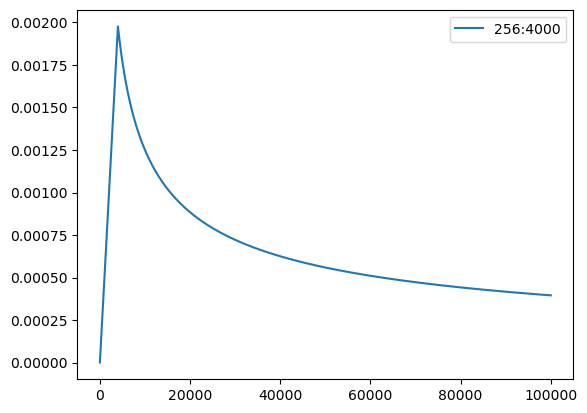

In [37]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim,
    factor=config.lr_factor,
    warmup=config.lr_warmup,
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 训练过程

## 训练

In [38]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累积：每 accum_steps 个样本更新一次

    stats = {"loss": []}
    scaler = GradScaler() # 自动混合精度（amp）

    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累积：每 accum_steps 个样本更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # 在第一步之后清空 CUDA 缓存可以减少 OOM（out of memory）的机会
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i

            # 混合精度训练
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))

                # 日志记录
                accum_loss += loss.item()
                # 反向传播
                scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) 处理零梯度的情况
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪防止梯度爆炸

        scaler.step(optimizer)
        scaler.update()

        # 日志记录
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })

    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## 验证 & 推测
为了防止过拟合，每个训练周期都需要进行验证，以验证模型在未见过的数据上的性能。
- 该过程与训练基本相同，只是多了一个推测步骤。
- 在验证后，我们可以保存模型的权重。

仅凭验证损失无法描述模型的实际性能
- 基于当前模型直接生成翻译假设，然后使用参考翻译计算BLEU
- 我们也可以手动检查假设的质量
- 我们使用 fairseq 的序列生成器进行集束搜索以生成翻译假设。

In [39]:
# fairseq 的集束搜索生成器
# 给定模型和输入序列，通过集束搜索生成翻译假设
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 将 Tensor 转换为人类可读的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 对于每个样本，收集输入、假设和参考，稍后用于计算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()),
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 表示使用集束中的最佳假设
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()),
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [40]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # 验证损失
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)

            # 做推测
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)

    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs

    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)

    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])

    # 显示 bleu 结果
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 保存和加载模型权重


In [41]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # 保存 epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)

        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")

        # 保存 epoch 样本
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # 获取最佳的验证 bleu
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")

        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()

    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## 训练循环

In [42]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [43]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-11-15 18:13:19 | INFO | hw5.seq2seq | task: TranslationTask
2023-11-15 18:13:19 | INFO | hw5.seq2seq | encoder: RNNEncoder
2023-11-15 18:13:19 | INFO | hw5.seq2seq | decoder: RNNDecoder
2023-11-15 18:13:19 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2023-11-15 18:13:19 | INFO | hw5.seq2seq | optimizer: NoamOpt
2023-11-15 18:13:19 | INFO | hw5.seq2seq | num. model params: 11,247,872 (num. trained: 11,247,872)
2023-11-15 18:13:19 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [44]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # 训练一个 epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-11-15 18:13:19 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:13:19 | INFO | fairseq.tasks.fairseq_task | reuse_dataloader = True
2023-11-15 18:13:19 | INFO | fairseq.tasks.fairseq_task | rebuild_batches = False
2023-11-15 18:13:19 | INFO | fairseq.tasks.fairseq_task | creating new batches for epoch 1
2023-11-15 18:13:19 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326653]
2023-11-15 18:13:19 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/checkpoint_last.pt!
2023-11-15 18:13:19 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 1:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:14:32 | INFO | hw5.seq2seq | training loss: 7.1006
2023-11-15 18:14:32 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:14:32 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:14:32 | INFO | fairseq.tasks.fairseq_task | reuse_dataloader = True
2023-11-15 18:14:32 | INFO | fairseq.tasks.fairseq_task | rebuild_batches = False
2023-11-15 18:14:32 | INFO | fairseq.tasks.fairseq_task | creating new batches for epoch 1


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:14:40 | INFO | hw5.seq2seq | example source: for the first time in the united states , a predominantly white group of voters voted for an africanamerican candidate for president .
2023-11-15 18:14:40 | INFO | hw5.seq2seq | example hypothesis: 一年 , 一年 , 一年 , 一年 , 一年 , 一年 。 」
2023-11-15 18:14:40 | INFO | hw5.seq2seq | example reference: 美國有史以來 , 大多數白人選民首次投票給一位非洲裔候選人
2023-11-15 18:14:40 | INFO | hw5.seq2seq | validation loss:	6.6061
2023-11-15 18:14:40 | INFO | hw5.seq2seq | BLEU = 0.05 17.1/0.6/0.0/0.0 (BP = 0.435 ratio = 0.546 hyp_len = 60297 ref_len = 110430)
2023-11-15 18:14:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint1.pt
2023-11-15 18:14:40 | INFO | hw5.seq2seq | end of epoch 1
2023-11-15 18:14:40 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:14:40 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 2:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:15:54 | INFO | hw5.seq2seq | training loss: 6.3447
2023-11-15 18:15:54 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:15:54 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:16:03 | INFO | hw5.seq2seq | example source: and it just sounds like the most egotistical request you could make , if you were going to pray .
2023-11-15 18:16:03 | INFO | hw5.seq2seq | example hypothesis: 很重要的 , 我們也要在這個人 , 會讓他們 , 都能做什麼 。
2023-11-15 18:16:03 | INFO | hw5.seq2seq | example reference: 這聽起來像是你所能想到的最自我中心的禱告祈求 。
2023-11-15 18:16:03 | INFO | hw5.seq2seq | validation loss:	5.9830
2023-11-15 18:16:03 | INFO | hw5.seq2seq | BLEU = 0.90 19.2/2.5/0.4/0.1 (BP = 0.865 ratio = 0.873 hyp_len = 96429 ref_len = 110430)
2023-11-15 18:16:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint2.pt
2023-11-15 18:16:03 | INFO | hw5.seq2seq | end of epoch 2
2023-11-15 18:16:03 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:16:03 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 3:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:17:18 | INFO | hw5.seq2seq | training loss: 5.7720
2023-11-15 18:17:18 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:17:18 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:17:28 | INFO | hw5.seq2seq | example source: but empathy really should get you points if you do it when it's hard to do .
2023-11-15 18:17:28 | INFO | hw5.seq2seq | example hypothesis: 但是 , 請你去做什麼事 , 你就知道你會做什麼事 。
2023-11-15 18:17:28 | INFO | hw5.seq2seq | example reference: 同理心應該是在很難有同理心的情況下產生才能夠得分才對 。
2023-11-15 18:17:28 | INFO | hw5.seq2seq | validation loss:	5.4271
2023-11-15 18:17:28 | INFO | hw5.seq2seq | BLEU = 2.07 18.7/3.7/0.9/0.3 (BP = 1.000 ratio = 1.109 hyp_len = 122463 ref_len = 110430)
2023-11-15 18:17:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint3.pt
2023-11-15 18:17:28 | INFO | hw5.seq2seq | end of epoch 3
2023-11-15 18:17:28 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:17:28 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 4:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:18:43 | INFO | hw5.seq2seq | training loss: 5.3017
2023-11-15 18:18:43 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:18:43 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:18:52 | INFO | hw5.seq2seq | example source: but most biologics also have a flaw .
2023-11-15 18:18:52 | INFO | hw5.seq2seq | example hypothesis: 但大部分生物的生物物種 。
2023-11-15 18:18:52 | INFO | hw5.seq2seq | example reference: 但 , 大部分的生物藥都有個瑕疵 。
2023-11-15 18:18:52 | INFO | hw5.seq2seq | validation loss:	4.9340
2023-11-15 18:18:52 | INFO | hw5.seq2seq | BLEU = 7.10 31.4/11.5/5.1/2.4 (BP = 0.869 ratio = 0.877 hyp_len = 96809 ref_len = 110430)
2023-11-15 18:18:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint4.pt
2023-11-15 18:18:52 | INFO | hw5.seq2seq | end of epoch 4
2023-11-15 18:18:52 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:18:52 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 5:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:20:06 | INFO | hw5.seq2seq | training loss: 4.9152
2023-11-15 18:20:06 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:20:06 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:20:15 | INFO | hw5.seq2seq | example source: but i believe now that we're moving into a new age , and that age the new york times dubbed recently as " the age of behavior . "
2023-11-15 18:20:15 | INFO | hw5.seq2seq | example hypothesis: 但我相信我們現在正在改變一個新的年齡 , 而這個年齡的歷史 , 《紐約時報》的時代 , 數位革命了新時代 。
2023-11-15 18:20:15 | INFO | hw5.seq2seq | example reference: 但我相信現在我們正在進入一個新的時代 , 而且最近這個時代被紐約時報稱為 「 行為的時代 」 。
2023-11-15 18:20:15 | INFO | hw5.seq2seq | validation loss:	4.5939
2023-11-15 18:20:15 | INFO | hw5.seq2seq | BLEU = 10.33 32.9/14.0/6.9/3.6 (BP = 1.000 ratio = 1.011 hyp_len = 111643 ref_len = 110430)
2023-11-15 18:20:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint5.pt
2023-11-15 18:20:15 | INFO | hw5.seq2seq | end of epoch 5
2023-11-15 18:20:15 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:20:15 | INFO | fairseq.data.iterators | grouped total

train epoch 6:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:21:29 | INFO | hw5.seq2seq | training loss: 4.6943
2023-11-15 18:21:29 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:21:29 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:21:38 | INFO | hw5.seq2seq | example source: as we have hot blood running through our veins and arteries , so , too , the earth has hot water running through its cracks and faults .
2023-11-15 18:21:38 | INFO | hw5.seq2seq | example hypothesis: 隨著我們的海豚和客戶來說 , 地球有熱水流行 , 所以 , 地球的水流動在我們的海域中 , 來到我們的海豚和客戶 。
2023-11-15 18:21:38 | INFO | hw5.seq2seq | example reference: 就如我們身體𥚃有熱騰騰的血液經過靜脈和動脈 , 同樣地 , 地球也有熱流穿過它的裂縫和斷層 。
2023-11-15 18:21:38 | INFO | hw5.seq2seq | validation loss:	4.3978
2023-11-15 18:21:38 | INFO | hw5.seq2seq | BLEU = 12.22 38.3/17.6/8.9/4.8 (BP = 0.936 ratio = 0.938 hyp_len = 103587 ref_len = 110430)
2023-11-15 18:21:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint6.pt
2023-11-15 18:21:38 | INFO | hw5.seq2seq | end of epoch 6
2023-11-15 18:21:38 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:21:38 | INFO | fairseq.data.iterators | gro

train epoch 7:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:22:52 | INFO | hw5.seq2seq | training loss: 4.5340
2023-11-15 18:22:52 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:22:52 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:23:01 | INFO | hw5.seq2seq | example source: entirely new requirement .
2023-11-15 18:23:01 | INFO | hw5.seq2seq | example hypothesis: 全新的需求 。
2023-11-15 18:23:01 | INFO | hw5.seq2seq | example reference: 這是全新的要求 。
2023-11-15 18:23:01 | INFO | hw5.seq2seq | validation loss:	4.3023
2023-11-15 18:23:01 | INFO | hw5.seq2seq | BLEU = 12.82 43.1/20.6/10.8/6.0 (BP = 0.828 ratio = 0.842 hyp_len = 92933 ref_len = 110430)
2023-11-15 18:23:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint7.pt
2023-11-15 18:23:01 | INFO | hw5.seq2seq | end of epoch 7
2023-11-15 18:23:01 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:23:01 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 8:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:24:14 | INFO | hw5.seq2seq | training loss: 4.4320
2023-11-15 18:24:14 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:24:14 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:24:23 | INFO | hw5.seq2seq | example source: by 1960 we had telephone bills , bank statements were being produced by computers .
2023-11-15 18:24:23 | INFO | hw5.seq2seq | example hypothesis: 1960年 , 銀行的銀行 , 銀行 , 銀行 , 銀行 , 銀行 , 銀行 , 銀行 , 銀行 。
2023-11-15 18:24:23 | INFO | hw5.seq2seq | example reference: 到了1960年 , 我們的電話和銀行帳單都交由電腦處理
2023-11-15 18:24:23 | INFO | hw5.seq2seq | validation loss:	4.1894
2023-11-15 18:24:23 | INFO | hw5.seq2seq | BLEU = 14.35 42.9/20.8/11.1/6.3 (BP = 0.909 ratio = 0.913 hyp_len = 100858 ref_len = 110430)
2023-11-15 18:24:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint8.pt
2023-11-15 18:24:23 | INFO | hw5.seq2seq | end of epoch 8
2023-11-15 18:24:23 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:24:23 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 9:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:25:37 | INFO | hw5.seq2seq | training loss: 4.3585
2023-11-15 18:25:37 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:25:37 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:25:46 | INFO | hw5.seq2seq | example source: they started making their own video games .
2023-11-15 18:25:46 | INFO | hw5.seq2seq | example hypothesis: 他們開始製作自己的影片遊戲 。
2023-11-15 18:25:46 | INFO | hw5.seq2seq | example reference: 他們開始製造自己的電玩遊戲 。
2023-11-15 18:25:46 | INFO | hw5.seq2seq | validation loss:	4.1391
2023-11-15 18:25:46 | INFO | hw5.seq2seq | BLEU = 15.06 43.1/21.1/11.3/6.3 (BP = 0.944 ratio = 0.946 hyp_len = 104423 ref_len = 110430)
2023-11-15 18:25:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint9.pt
2023-11-15 18:25:46 | INFO | hw5.seq2seq | end of epoch 9
2023-11-15 18:25:46 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:25:46 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 10:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:27:01 | INFO | hw5.seq2seq | training loss: 4.2966
2023-11-15 18:27:01 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:27:01 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:27:11 | INFO | hw5.seq2seq | example source: a perfect example of this is spanish contemporary artist fernando vicente .
2023-11-15 18:27:11 | INFO | hw5.seq2seq | example hypothesis: 一個完美的例子是西班牙藝術家甘迺迪 。
2023-11-15 18:27:11 | INFO | hw5.seq2seq | example reference: 一個最有代表性的例子是西班牙現代藝術家費南多·維森特 。
2023-11-15 18:27:11 | INFO | hw5.seq2seq | validation loss:	4.0866
2023-11-15 18:27:11 | INFO | hw5.seq2seq | BLEU = 15.55 42.8/20.9/11.3/6.3 (BP = 0.978 ratio = 0.978 hyp_len = 107978 ref_len = 110430)
2023-11-15 18:27:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint10.pt
2023-11-15 18:27:11 | INFO | hw5.seq2seq | end of epoch 10
2023-11-15 18:27:11 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:27:11 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 11:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:28:26 | INFO | hw5.seq2seq | training loss: 4.2502
2023-11-15 18:28:26 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:28:26 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:28:36 | INFO | hw5.seq2seq | example source: right . as you can see , bart simpson is having a little argument .
2023-11-15 18:28:36 | INFO | hw5.seq2seq | example hypothesis: 如你所見 , 巴特·史蒂芬森的辯論是有一些辯論 。
2023-11-15 18:28:36 | INFO | hw5.seq2seq | example reference: 好 , 如你所見bartsimpson正和它老爸爭執
2023-11-15 18:28:36 | INFO | hw5.seq2seq | validation loss:	4.0442
2023-11-15 18:28:36 | INFO | hw5.seq2seq | BLEU = 15.36 41.0/20.2/10.9/6.2 (BP = 1.000 ratio = 1.051 hyp_len = 116094 ref_len = 110430)
2023-11-15 18:28:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint11.pt
2023-11-15 18:28:36 | INFO | hw5.seq2seq | end of epoch 11
2023-11-15 18:28:36 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:28:36 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 12:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:29:50 | INFO | hw5.seq2seq | training loss: 4.2093
2023-11-15 18:29:50 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:29:50 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:29:59 | INFO | hw5.seq2seq | example source: and if we look to the future , it's an unsustainable diet .
2023-11-15 18:29:59 | INFO | hw5.seq2seq | example hypothesis: 如果我們看看未來 , 它是永續的飲食 。
2023-11-15 18:29:59 | INFO | hw5.seq2seq | example reference: 如果我們想一想未來這絕不是長久之計
2023-11-15 18:29:59 | INFO | hw5.seq2seq | validation loss:	4.0163
2023-11-15 18:29:59 | INFO | hw5.seq2seq | BLEU = 16.40 45.4/22.8/12.4/7.1 (BP = 0.945 ratio = 0.946 hyp_len = 104481 ref_len = 110430)
2023-11-15 18:29:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint12.pt
2023-11-15 18:29:59 | INFO | hw5.seq2seq | end of epoch 12
2023-11-15 18:29:59 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:29:59 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 13:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:31:13 | INFO | hw5.seq2seq | training loss: 4.1805
2023-11-15 18:31:13 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:31:13 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:31:22 | INFO | hw5.seq2seq | example source: when you govern through fear and you govern through cruelty , it just doesn't work .
2023-11-15 18:31:22 | INFO | hw5.seq2seq | example hypothesis: 當你從恐懼中走過來 , 只是沒有工作 。
2023-11-15 18:31:22 | INFO | hw5.seq2seq | example reference: 透過恐懼 , 透過殘忍來治理國家 , 這是行不通的 。
2023-11-15 18:31:22 | INFO | hw5.seq2seq | validation loss:	3.9980
2023-11-15 18:31:22 | INFO | hw5.seq2seq | BLEU = 16.40 45.7/22.9/12.5/7.2 (BP = 0.938 ratio = 0.940 hyp_len = 103799 ref_len = 110430)
2023-11-15 18:31:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint13.pt
2023-11-15 18:31:22 | INFO | hw5.seq2seq | end of epoch 13
2023-11-15 18:31:22 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:31:22 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 14:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:32:35 | INFO | hw5.seq2seq | training loss: 4.1507
2023-11-15 18:32:35 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:32:35 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:32:44 | INFO | hw5.seq2seq | example source: this project breaks ground in just two months .
2023-11-15 18:32:44 | INFO | hw5.seq2seq | example hypothesis: 這個計畫打破了兩個月 。
2023-11-15 18:32:44 | INFO | hw5.seq2seq | example reference: 這個計畫再兩個月就要開工了 。
2023-11-15 18:32:44 | INFO | hw5.seq2seq | validation loss:	3.9808
2023-11-15 18:32:44 | INFO | hw5.seq2seq | BLEU = 16.61 46.6/23.6/12.9/7.4 (BP = 0.924 ratio = 0.927 hyp_len = 102377 ref_len = 110430)
2023-11-15 18:32:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint14.pt
2023-11-15 18:32:44 | INFO | hw5.seq2seq | end of epoch 14
2023-11-15 18:32:44 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:32:44 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 15:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:33:58 | INFO | hw5.seq2seq | training loss: 4.1270
2023-11-15 18:33:58 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:33:58 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:34:07 | INFO | hw5.seq2seq | example source: and these preservatives had been found in breast cancer tumors .
2023-11-15 18:34:07 | INFO | hw5.seq2seq | example hypothesis: 這些保守派已經發現了乳癌腫瘤 。
2023-11-15 18:34:07 | INFO | hw5.seq2seq | example reference: 而乳癌腫瘤中也發現了這些防腐劑 。
2023-11-15 18:34:07 | INFO | hw5.seq2seq | validation loss:	3.9614
2023-11-15 18:34:07 | INFO | hw5.seq2seq | BLEU = 16.97 46.8/23.9/13.1/7.6 (BP = 0.931 ratio = 0.933 hyp_len = 103073 ref_len = 110430)
2023-11-15 18:34:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint15.pt
2023-11-15 18:34:07 | INFO | hw5.seq2seq | end of epoch 15
2023-11-15 18:34:07 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:34:07 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 16:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:35:21 | INFO | hw5.seq2seq | training loss: 4.1043
2023-11-15 18:35:21 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:35:21 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:35:30 | INFO | hw5.seq2seq | example source: history is strewn with the cases when they've all got it wrong .
2023-11-15 18:35:30 | INFO | hw5.seq2seq | example hypothesis: 歷史是從這些情況下降低的 , 當他們有了錯誤的情況時 , 他們都錯了 。
2023-11-15 18:35:30 | INFO | hw5.seq2seq | example reference: 歷史上到處都有我們全都錯了的實例
2023-11-15 18:35:30 | INFO | hw5.seq2seq | validation loss:	3.9372
2023-11-15 18:35:30 | INFO | hw5.seq2seq | BLEU = 17.27 44.6/22.5/12.4/7.2 (BP = 1.000 ratio = 1.000 hyp_len = 110457 ref_len = 110430)
2023-11-15 18:35:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint16.pt
2023-11-15 18:35:30 | INFO | hw5.seq2seq | end of epoch 16
2023-11-15 18:35:30 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:35:30 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 17:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:36:44 | INFO | hw5.seq2seq | training loss: 4.0858
2023-11-15 18:36:44 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:36:44 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:36:53 | INFO | hw5.seq2seq | example source: please raise your hand if something applies to you .
2023-11-15 18:36:53 | INFO | hw5.seq2seq | example hypothesis: 請舉起你的手 , 請舉舉你的手 。
2023-11-15 18:36:53 | INFO | hw5.seq2seq | example reference: 如果這些事曾發生在你身上請舉手 。
2023-11-15 18:36:53 | INFO | hw5.seq2seq | validation loss:	3.9238
2023-11-15 18:36:53 | INFO | hw5.seq2seq | BLEU = 17.58 45.0/22.9/12.6/7.3 (BP = 1.000 ratio = 1.008 hyp_len = 111361 ref_len = 110430)
2023-11-15 18:36:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint17.pt
2023-11-15 18:36:53 | INFO | hw5.seq2seq | end of epoch 17
2023-11-15 18:36:53 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:36:53 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 18:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:38:07 | INFO | hw5.seq2seq | training loss: 4.0693
2023-11-15 18:38:07 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:38:07 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:38:16 | INFO | hw5.seq2seq | example source: and the fact is , millions is a gross estimate , because we don't really know how many kids die each year of this .
2023-11-15 18:38:16 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 數百萬的悲劇是 , 因為我們不知道每年有多少孩子死亡 。
2023-11-15 18:38:16 | INFO | hw5.seq2seq | example reference: 而且事實是 , 數百萬只是一個粗略的估計 , 因為我們真的不知道每年究竟有多少孩子死於這些疾病 。
2023-11-15 18:38:16 | INFO | hw5.seq2seq | validation loss:	3.9136
2023-11-15 18:38:16 | INFO | hw5.seq2seq | BLEU = 17.74 45.3/23.1/12.7/7.4 (BP = 1.000 ratio = 1.004 hyp_len = 110826 ref_len = 110430)
2023-11-15 18:38:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint18.pt
2023-11-15 18:38:17 | INFO | hw5.seq2seq | end of epoch 18
2023-11-15 18:38:17 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:38:17 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 19:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:39:30 | INFO | hw5.seq2seq | training loss: 4.0533
2023-11-15 18:39:30 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:39:30 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:39:39 | INFO | hw5.seq2seq | example source: and he didn’t know it at the time , but over the next five decades , he'd draw on these dueling identities to forge a whole new way to think about pain .
2023-11-15 18:39:39 | INFO | hw5.seq2seq | example hypothesis: 當時他還沒知道 , 但在接下來的五十年 , 他會畫出這張圖片 , 去思考痛苦 。
2023-11-15 18:39:39 | INFO | hw5.seq2seq | example reference: 在那時他並不知道但在接下來的50年他將會利用這兩個相對決的生命經驗去探索關於疼痛的新思路
2023-11-15 18:39:39 | INFO | hw5.seq2seq | validation loss:	3.9054
2023-11-15 18:39:39 | INFO | hw5.seq2seq | BLEU = 17.98 46.0/23.6/13.0/7.6 (BP = 0.993 ratio = 0.993 hyp_len = 109710 ref_len = 110430)
2023-11-15 18:39:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint19.pt
2023-11-15 18:39:39 | INFO | hw5.seq2seq | end of epoch 19
2023-11-15 18:39:39 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:39:39 | INFO | fairseq.data.iterators | grou

train epoch 20:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:40:53 | INFO | hw5.seq2seq | training loss: 4.0388
2023-11-15 18:40:53 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:40:53 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:41:02 | INFO | hw5.seq2seq | example source: and i have been fortunate enough to find things like the first eggs in the western hemisphere and the first baby dinosaurs in nests , the first dinosaur embryos and massive accumulations of bones .
2023-11-15 18:41:02 | INFO | hw5.seq2seq | example hypothesis: 我很幸運能找到像第一個嬰兒恐龍胚胎和大大的蛋 , 在西半球中 , 第一個嬰兒恐龍胚胎和大大的蛋 。
2023-11-15 18:41:02 | INFO | hw5.seq2seq | example reference: 和我已經夠幸運能找到在西半球裡的第一只蛋和第一只恐龍寶寶在巢裡第一個恐龍胚胎和大量積累的骨頭
2023-11-15 18:41:02 | INFO | hw5.seq2seq | validation loss:	3.9010
2023-11-15 18:41:02 | INFO | hw5.seq2seq | BLEU = 17.78 47.0/24.0/13.2/7.7 (BP = 0.967 ratio = 0.967 hyp_len = 106821 ref_len = 110430)
2023-11-15 18:41:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint20.pt
2023-11-15 18:41:02 | INFO | hw5.seq2seq | end of epoch 20
2023-11-15 18:41:02 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
202

train epoch 21:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:42:15 | INFO | hw5.seq2seq | training loss: 4.0245
2023-11-15 18:42:15 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:42:15 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:42:24 | INFO | hw5.seq2seq | example source: we've had the biggest transformation of any ancient subject that i could ever imagine with computers .
2023-11-15 18:42:24 | INFO | hw5.seq2seq | example hypothesis: 我們有最大的轉變 , 可能我能想像到電腦 , 任何古代主題都可以想像 。
2023-11-15 18:42:25 | INFO | hw5.seq2seq | example reference: 我們經歷了電腦這個最大的變革比任何古往的科目都要巨大
2023-11-15 18:42:25 | INFO | hw5.seq2seq | validation loss:	3.8818
2023-11-15 18:42:25 | INFO | hw5.seq2seq | BLEU = 18.18 46.3/23.6/13.1/7.6 (BP = 1.000 ratio = 1.006 hyp_len = 111137 ref_len = 110430)
2023-11-15 18:42:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint21.pt
2023-11-15 18:42:25 | INFO | hw5.seq2seq | end of epoch 21
2023-11-15 18:42:25 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:42:25 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 22:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:43:38 | INFO | hw5.seq2seq | training loss: 4.0140
2023-11-15 18:43:38 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:43:38 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:43:47 | INFO | hw5.seq2seq | example source: there is another visual phenomenon that looks similar to floaters but is in fact unrelated .
2023-11-15 18:43:47 | INFO | hw5.seq2seq | example hypothesis: 這裡有另一個視覺現象 , 看起來相似的視覺現象 , 但事實不相關 。
2023-11-15 18:43:47 | INFO | hw5.seq2seq | example reference: 還有另一個視覺現象看起來像飛蚊症但其實毫無關連
2023-11-15 18:43:47 | INFO | hw5.seq2seq | validation loss:	3.8889
2023-11-15 18:43:47 | INFO | hw5.seq2seq | BLEU = 17.99 46.7/24.0/13.3/7.7 (BP = 0.977 ratio = 0.978 hyp_len = 107965 ref_len = 110430)
2023-11-15 18:43:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint22.pt
2023-11-15 18:43:47 | INFO | hw5.seq2seq | end of epoch 22
2023-11-15 18:43:47 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:43:47 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 23:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:45:00 | INFO | hw5.seq2seq | training loss: 4.0036
2023-11-15 18:45:00 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:45:00 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:45:10 | INFO | hw5.seq2seq | example source: ynh: yes , very much so .
2023-11-15 18:45:10 | INFO | hw5.seq2seq | example hypothesis: 尤:是的 , 太多了 。
2023-11-15 18:45:10 | INFO | hw5.seq2seq | example reference: 尤:是的 , 就是這樣 。
2023-11-15 18:45:10 | INFO | hw5.seq2seq | validation loss:	3.8757
2023-11-15 18:45:10 | INFO | hw5.seq2seq | BLEU = 17.90 45.6/23.2/12.9/7.5 (BP = 1.000 ratio = 1.024 hyp_len = 113044 ref_len = 110430)
2023-11-15 18:45:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint23.pt
2023-11-15 18:45:10 | INFO | hw5.seq2seq | end of epoch 23
2023-11-15 18:45:10 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:45:10 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 24:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:46:23 | INFO | hw5.seq2seq | training loss: 3.9916
2023-11-15 18:46:23 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:46:23 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:46:32 | INFO | hw5.seq2seq | example source: but the first thing you need to do is let go of the bad ideas you have about sex .
2023-11-15 18:46:32 | INFO | hw5.seq2seq | example hypothesis: 但你要做的第一件事 , 就是讓壞點子在性別上 。
2023-11-15 18:46:32 | INFO | hw5.seq2seq | example reference: 但你需要先做一件事 , 放掉你對於性愛的不好想法 。
2023-11-15 18:46:32 | INFO | hw5.seq2seq | validation loss:	3.8649
2023-11-15 18:46:32 | INFO | hw5.seq2seq | BLEU = 18.27 47.0/24.1/13.4/7.8 (BP = 0.985 ratio = 0.985 hyp_len = 108820 ref_len = 110430)
2023-11-15 18:46:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint24.pt
2023-11-15 18:46:32 | INFO | hw5.seq2seq | end of epoch 24
2023-11-15 18:46:32 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:46:32 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 25:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:47:45 | INFO | hw5.seq2seq | training loss: 3.9839
2023-11-15 18:47:45 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:47:45 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:47:54 | INFO | hw5.seq2seq | example source: those subsidies stop companies from competing on equal terms .
2023-11-15 18:47:54 | INFO | hw5.seq2seq | example hypothesis: 那些補助者停止公司從競爭對平等等等 。
2023-11-15 18:47:54 | INFO | hw5.seq2seq | example reference: 那些補助 , 阻礙了公司之間的公平競爭 。
2023-11-15 18:47:54 | INFO | hw5.seq2seq | validation loss:	3.8574
2023-11-15 18:47:54 | INFO | hw5.seq2seq | BLEU = 18.25 47.2/24.3/13.5/7.9 (BP = 0.976 ratio = 0.976 hyp_len = 107765 ref_len = 110430)
2023-11-15 18:47:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint25.pt
2023-11-15 18:47:54 | INFO | hw5.seq2seq | end of epoch 25
2023-11-15 18:47:54 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:47:54 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 26:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:49:07 | INFO | hw5.seq2seq | training loss: 3.9701
2023-11-15 18:49:07 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:49:07 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:49:16 | INFO | hw5.seq2seq | example source: i believe so , but before we move on , what do we mean by democracy ?
2023-11-15 18:49:16 | INFO | hw5.seq2seq | example hypothesis: 我相信 , 但在我們移動之前 , 我們要怎麼說 ?
2023-11-15 18:49:16 | INFO | hw5.seq2seq | example reference: 我相信是對的 , 但在我們繼續談下去之前 , 我們所說的民主是什麼 ?
2023-11-15 18:49:16 | INFO | hw5.seq2seq | validation loss:	3.8530
2023-11-15 18:49:16 | INFO | hw5.seq2seq | BLEU = 18.28 47.5/24.5/13.6/7.9 (BP = 0.971 ratio = 0.971 hyp_len = 107269 ref_len = 110430)
2023-11-15 18:49:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint26.pt
2023-11-15 18:49:16 | INFO | hw5.seq2seq | end of epoch 26
2023-11-15 18:49:16 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:49:16 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 27:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:50:30 | INFO | hw5.seq2seq | training loss: 3.9627
2023-11-15 18:50:30 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:50:30 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:50:39 | INFO | hw5.seq2seq | example source: so , a team of berkeley researchers with 15 million dollars from the gates foundation is engineering , designing a radical new way to make the key ingredient , called artemisinin , and they're going to make that drug 10 times cheaper .
2023-11-15 18:50:39 | INFO | hw5.seq2seq | example hypothesis: 因此 , 一位團隊成員 , 在gates基金會的團隊中 , 設計了一個新的方法 , 創造出一種新的方法 , 創造出一種新的方法 , 來製造出一種更便宜的新方法 , 叫做 「 糖尿病 」 , 大約有15百萬美元 。
2023-11-15 18:50:39 | INFO | hw5.seq2seq | example reference: 柏克萊的團隊得到gatesfoundation的1千5百萬的經費 , 以研發設計一顛覆式的新方法來製造一個叫 " 青蒿素 " 的關鍵成分希望能製造出10倍便宜的藥物
2023-11-15 18:50:39 | INFO | hw5.seq2seq | validation loss:	3.8493
2023-11-15 18:50:39 | INFO | hw5.seq2seq | BLEU = 18.45 47.2/24.3/13.5/7.9 (BP = 0.988 ratio = 0.988 hyp_len = 109148 ref_len = 110430)
2023-11-15 18:50:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint27.pt
2023-11-15 18:50

train epoch 28:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:51:52 | INFO | hw5.seq2seq | training loss: 3.9559
2023-11-15 18:51:52 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:51:52 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:52:01 | INFO | hw5.seq2seq | example source: even another black hole won’t destroy it– the two will simply merge into a larger black hole , releasing a bit of energy as gravitational waves in the process .
2023-11-15 18:52:01 | INFO | hw5.seq2seq | example hypothesis: 即使另一個黑洞 , 不會摧毀它 , 兩者會將能量轉換成更大的黑洞 , 將能量轉換為重力波 。
2023-11-15 18:52:01 | INFO | hw5.seq2seq | example reference: 就連另一個黑洞也無法摧毀它 , 兩個黑洞只會融合成一個更大的黑洞 , 在過程中以重力波的形式釋放出一點能量 。
2023-11-15 18:52:01 | INFO | hw5.seq2seq | validation loss:	3.8453
2023-11-15 18:52:01 | INFO | hw5.seq2seq | BLEU = 18.53 47.1/24.2/13.4/7.9 (BP = 0.996 ratio = 0.996 hyp_len = 109952 ref_len = 110430)
2023-11-15 18:52:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint28.pt
2023-11-15 18:52:01 | INFO | hw5.seq2seq | end of epoch 28
2023-11-15 18:52:01 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:52:01 | INFO | fairs

train epoch 29:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:53:14 | INFO | hw5.seq2seq | training loss: 3.9466
2023-11-15 18:53:14 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:53:14 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:53:23 | INFO | hw5.seq2seq | example source: but the question is: can we own our duality ?
2023-11-15 18:53:23 | INFO | hw5.seq2seq | example hypothesis: 但問題是:我們是否能擁有我們的責任 ?
2023-11-15 18:53:23 | INFO | hw5.seq2seq | example reference: 但問題是:我們能擁有屬於我們的二元性嗎 ?
2023-11-15 18:53:23 | INFO | hw5.seq2seq | validation loss:	3.8393
2023-11-15 18:53:23 | INFO | hw5.seq2seq | BLEU = 18.70 47.4/24.5/13.6/7.9 (BP = 0.993 ratio = 0.993 hyp_len = 109710 ref_len = 110430)
2023-11-15 18:53:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint29.pt
2023-11-15 18:53:23 | INFO | hw5.seq2seq | end of epoch 29
2023-11-15 18:53:23 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:53:23 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 30:   0%|          | 0/790 [00:00<?, ?it/s]

2023-11-15 18:54:36 | INFO | hw5.seq2seq | training loss: 3.9400
2023-11-15 18:54:36 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:54:36 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:54:46 | INFO | hw5.seq2seq | example source: be serious , it says .
2023-11-15 18:54:46 | INFO | hw5.seq2seq | example hypothesis: 很嚴肅 , 說了 。
2023-11-15 18:54:46 | INFO | hw5.seq2seq | example reference: 嚴肅起來 , 信裡寫道
2023-11-15 18:54:46 | INFO | hw5.seq2seq | validation loss:	3.8368
2023-11-15 18:54:46 | INFO | hw5.seq2seq | BLEU = 17.98 45.7/23.3/12.9/7.6 (BP = 1.000 ratio = 1.044 hyp_len = 115328 ref_len = 110430)
2023-11-15 18:54:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/hoperj/DeepLearning/HUNG-YI_LEE_Machine-Learning_Homework/HW05/zh/checkpoints/rnn/checkpoint30.pt
2023-11-15 18:54:46 | INFO | hw5.seq2seq | end of epoch 30
2023-11-15 18:54:46 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


# Submission

In [45]:
# 对几个 checkpoints 进行平均可以产生类似于 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(inputs=['./checkpoints/rnn'], output='./checkpoints/rnn/avg_last_5_checkpoint.pt', num_epoch_checkpoints=5, num_update_checkpoints=None, num_best_checkpoints=0, checkpoint_upper_bound=None)
averaging checkpoints:  ['./checkpoints/rnn/checkpoint30.pt', './checkpoints/rnn/checkpoint29.pt', './checkpoints/rnn/checkpoint28.pt', './checkpoints/rnn/checkpoint27.pt', './checkpoints/rnn/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## 确定用于生成 submission 的模型权重

In [46]:
# checkpoint_last.pt : 最新的 epoch
# checkpoint_best.pt : 最高的验证 BLEU
# avg_last_5_checkpoint.pt: 最近 5 次 epoch 的平均值
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2023-11-15 18:54:48 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.8368029594421387 bleu=17.978629598087807
2023-11-15 18:54:48 | INFO | hw5.seq2seq | begin validation
2023-11-15 18:54:48 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-11-15 18:54:57 | INFO | hw5.seq2seq | example source: and there is also a frontier in research physics here , it's just that nobody talks about it .
2023-11-15 18:54:57 | INFO | hw5.seq2seq | example hypothesis: 在研究物理學的領域中 , 這裡有一件更重要的事 , 沒人會談論它 。
2023-11-15 18:54:57 | INFO | hw5.seq2seq | example reference: 這裡也有物理研究中尚未完全開拓的疆界 , 只是沒有人在談論它 。
2023-11-15 18:54:57 | INFO | hw5.seq2seq | validation loss:	3.8031
2023-11-15 18:54:57 | INFO | hw5.seq2seq | BLEU = 18.90 47.6/24.6/13.8/8.1 (BP = 0.994 ratio = 0.994 hyp_len = 109812 ref_len = 110430)


## 生成预测

In [47]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # 验证损失
            sample = utils.move_to_cuda(sample, device=device)

            # 做推测
            s, h, r = inference_step(sample, model)

            hyps.extend(h)
            idxs.extend(list(sample['id']))

    # 根据预处理前的顺序进行排序
    hyps = [x for _,x in sorted(zip(idxs,hyps))]

    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [48]:
generate_prediction(model, task)

2023-11-15 18:54:57 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2023-11-15 18:54:57 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2023-11-15 18:54:57 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples
2023-11-15 18:54:57 | INFO | fairseq.tasks.fairseq_task | can_reuse_epoch_itr = True
2023-11-15 18:54:57 | INFO | fairseq.tasks.fairseq_task | reuse_dataloader = True
2023-11-15 18:54:57 | INFO | fairseq.tasks.fairseq_task | rebuild_batches = False
2023-11-15 18:54:57 | INFO | fairseq.tasks.fairseq_task | creating new batches for epoch 1


prediction:   0%|          | 0/18 [00:00<?, ?it/s]

In [49]:
raise

RuntimeError: No active exception to reraise

# Back-translation

## 训练一个 backward translation 模型

1. 将 **config** 中的 source_lang 和 target_lang 进行切换
2. 更改 **config** 中的 savedir(例如: "./checkpoints/transformer-back")
3. 训练模型

## 用后向模型生成人造数据

### 下载单语言数据

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: 清洗语料

1. 移除太长或者太短的句子
2. 统一标点符号

提示: 你可以使用之前定义的 clean_s() 来执行此操作

### TODO: 子词单位

使用后向模型的 spm 模型将数据标记为子词单位

提示: spm 模型位于 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### 二值化

使用 fairseq 去二值化数据

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: 用后向模型生成人造数据

将二进制化的单语言数据添加到原始数据目录中，并将其命名为 "split_name"

例如: ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

然后你可以使用 'generate_prediction(model, task, split="split_name")' 来生成翻译的预测

In [ ]:
# 将二进制化的单语言数据添加到原始数据目录中，并将其命名为 "split_name"
# 例如: ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: 在 split='mono' 上做预测来创建 prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: 创建新的数据集

1. 将预测数据和单语数据结合
2. 使用原始的 spm 模型将数据 tokenize 为子词单位
3. 使用 fairseq 将数据二值化

In [ ]:
# 将 prediction_file (.en) 和 mono.zh (.zh) 结合为新的数据集
#
# 提示: 用 spm 模型 tokenize prediction_file
# spm_model.encode(line, out_type=str)
# 输出: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# 提示: 使用 fairseq 再次二值化这两个文件
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = './DATA/rawdata/mono/mono.tok' # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# 根据上面准备的所有文件创建一个新的数据集
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

创建新数据集 "ted2020_with_mono"

1. 修改 **config** 中的 datadir ("./DATA/data-bin/ted2020_with_mono")
2. 将 **config** 中的 source_lang 和 target_lang 进行切换 ("en", "zh")
2. 更改 **config** 中的 savedir (例如: "./checkpoints/transformer-bt")
3. 训练模型

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb